# ローカルレベルモデル

ローカルレベルモデルは動的線形モデルの基本的なモデルで、状態変数がランダムウォークしていると仮定するモデルである。ローカルレベルモデルは次のように表される。
$$
\mu_t = \mu_{t-1} + w_t \quad w_t \sim Normal(0, \sigma_t^2) \\
y_t = \mu_t + v_t \quad v_t \sim Normal(0, \sigma_v^2)
$$
まず、ホワイトノイズとランダムウォークについて説明し、ローカルレベルモデルによるモデル化を実装する。

## ホワイトノイズ
ホワイトノイズとは期待値が0で分散が一定であり、同時刻以外の自己相関が0であるような時系列データのことを言う。式にすると次のようになる。
$$
\Epsilon[\epsilon_t] = 0 \\
Cov(\epsilon_{t_1}, \epsilon_{t_2}) = \sigma^2\delta(t_1-t_2)
$$
自己相関が0かつデータが独立である系列データをi.i.d系列という。

特にノイズが正規分布に従う場合を正規ホワイトノイズといい、次のように書ける。
$$
\epsilon_t \sim Normal(0, \sigma^2)
$$
ホワイトノイズは時系列モデルの部品として重要な意味を持つ。

例えば次のようなモデルを考えることができる。
$$
y_t \sim Normal(\mu, \sigma^2)
$$
このモデルは誤差がホワイトノイズになっており、観測値は期待値$\mu$の周りをばらつくことをモデル化している。これだけでは、時系列の構造をモデル化できているとは言えないが、次のランダムウォークや動的線形モデルを構築する上でホワイトノイズは重要になる。

## ランダムウォーク
ランダムウォークはi.i.d系列の累積和からなる系列で、ホワイトノイズの累積和は次のように書ける。
$$
y_t = y_{t-1} +\epsilon_t \qquad \epsilon_t \sim Normal(0, \sigma^2) \\
y_t \sim Normal(y_{t-1}, \sigma^2)
$$
ホワイトノイズでは時系列の構造をモデル化できていないが、ランダムウォークはある時点の観測値が前の時点に依存しているので、時系列の構造を表現できていると言える。

ランダムウォークとホワイトノイズの違いを可視化して見ていく。

In [2]:
import numpy as np
import matplotlib.pyplot as plt

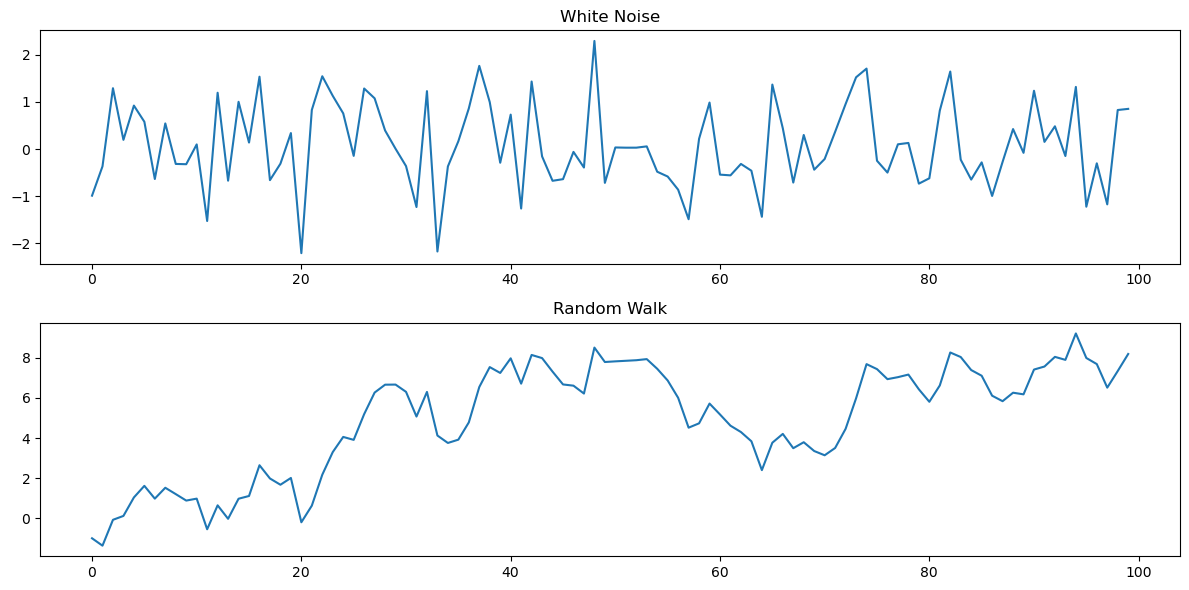

In [5]:
rng = np.random.default_rng(123)
white_noise = rng.normal(size=100)
random_walk = np.cumsum(white_noise)

fig,axes = plt.subplots(2,1,figsize=(12,6))
axes[0].plot(white_noise)
axes[0].set_title('White Noise')
axes[1].plot(random_walk)
axes[1].set_title('Random Walk')
plt.tight_layout()

ホワイトノイズでは0の周りをばらついているが、ランダムウォークでは0から離れて大きな値に変化している。しかし、ランダムウォークが正の大きな値になったのはたまたまで、次のように様々な方向に散らばることもある。

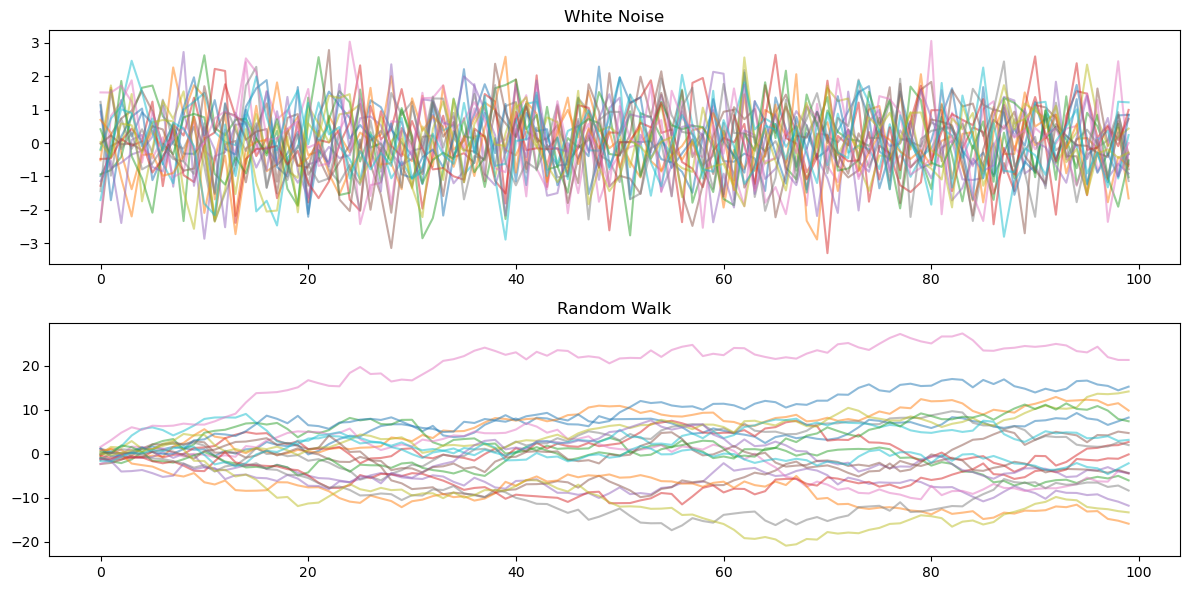

In [7]:
rng = np.random.default_rng(123)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for i in range(20):
    white_noise = rng.normal(size=100)
    random_walk = np.cumsum(white_noise)
    axes[0].plot(white_noise, alpha=0.5)
    axes[1].plot(random_walk, alpha=0.5)
axes[0].set_title('White Noise')
axes[1].set_title('Random Walk')
plt.tight_layout()

ホワイトノイズとランダムウォークを20回繰り返した場合では、ホワイトノイズは常に0の周りをばらつくが、ランダムウォークは正の値に大きくなったり、負の値に大きくなったり0に戻ってきたりしている。これは、期待値0から始めたランダムウォークのn回目の値が
$$
y_t = \sum_{i=1}^t\epsilon_i
$$
と、誤差の和になっているためである。そのため、ランダムウォークではたまたま大きな値が一回でも出れば、その値の影響を常にひきづることになる。

## ローカルレベルモデル
ローカルレベルモデルはランダムウォークプラスノイズモデルとも呼ばれ、正規ホワイトノイズモデルとランダムウォークを使って次のように書ける。
$$
\mu_t = \mu_{t-1} + w_t, \qquad w_t \sim Normal(0, \sigma_w^2) \\
y_t = \mu_t + v_t \qquad v_t \sim Normal(0, \sigma_v^2)
$$
$w_t, v_t$はそれぞれ過程誤差、観測誤差と呼ばれる。ローカルレベルモデルは状態がランダムウォークによって変化し、観測値が正規ホワイトノイズに従う。ここで、過程誤差は状態の変化の大きさを表し、$\sigma_w^2$は状態の変化の大きさを表すパラメータであると言える。一方$v_t$は状態と実際の観測のずれを表し、$\sigma_v^2$はスレの大きさを表すパラメータであると言える。

ローカルレベルモデルは次のように書き換えることができる。
$$
\mu_t \sim Normal(\mu_{t-1}, \sigma_w^2) \\
y_t \sim Normal(\mu_t, \sigma_v^2)
$$
これは、パラメータ$\mu_t$に確率分布を仮定した階層ベイズモデルと言える。

pymcでは状態空間モデルがデフォルトでは実装されていないため、pymc-experimentalを利用してモデル化する。

しかし使い方が分からないのでpystanのみ実装する。

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
sales = pd.read_csv('../data/4-2-sales.csv')

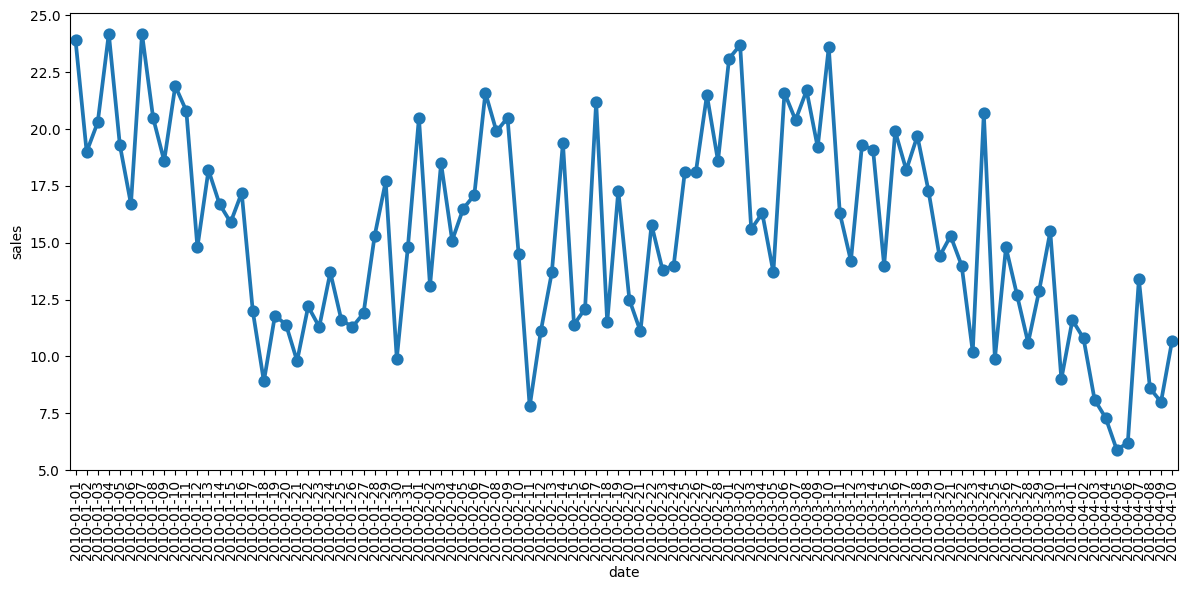

In [3]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
sns.pointplot(x='date', y='sales', data=sales, ax=axes)
plt.xticks(rotation=90)
plt.tight_layout()

このように1日ごとに売り上げが変化する構造をローカルレベルモデルでモデル化する

In [3]:
sales = pd.read_csv('../data/4-2-sales.csv')

In [4]:
sale = sales['sales'].values

In [5]:
stan_data = {
    "T": len(sale),
    "y": sale
}

In [6]:
with open("../stan/4-2-local-level-model.stan", "r") as f:
    stan_code = f.read()

In [7]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/brna6zjd/model_brna6zjd.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 23.0s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [11]:
fit = sm.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:   1% (200/30000)
Sampling:   2% (500/30000)
Sampling:   3% (800/30000)
Sampling:  35% (10600/30000)
Sampling:  68% (20300/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 0.00031 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_h9ws7sbx/model_brna6zjd.stan', line 14, column 8 to column 37)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this wa

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],21.529,1.743,18.083,24.649,0.019,0.013,8778.0,8663.0,1.0
mu[1],20.993,1.510,18.264,23.929,0.016,0.011,8823.0,8013.0,1.0
mu[2],20.939,1.417,18.145,23.474,0.015,0.011,9041.0,8637.0,1.0
mu[3],21.038,1.396,18.461,23.685,0.015,0.011,8791.0,8299.0,1.0
mu[4],20.453,1.374,17.871,23.078,0.014,0.010,9286.0,8626.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[97],9.240,1.431,6.598,11.963,0.015,0.011,8870.0,8863.0,1.0
mu[98],9.222,1.512,6.396,11.990,0.016,0.011,9076.0,8483.0,1.0
mu[99],9.492,1.743,6.138,12.624,0.018,0.013,8969.0,8803.0,1.0
s_w,1.317,0.299,0.772,1.859,0.006,0.004,2230.0,4095.0,1.0


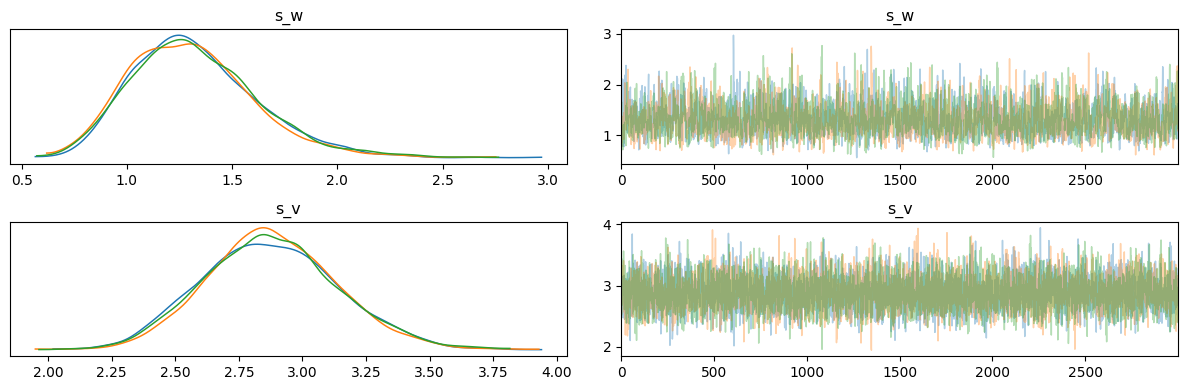

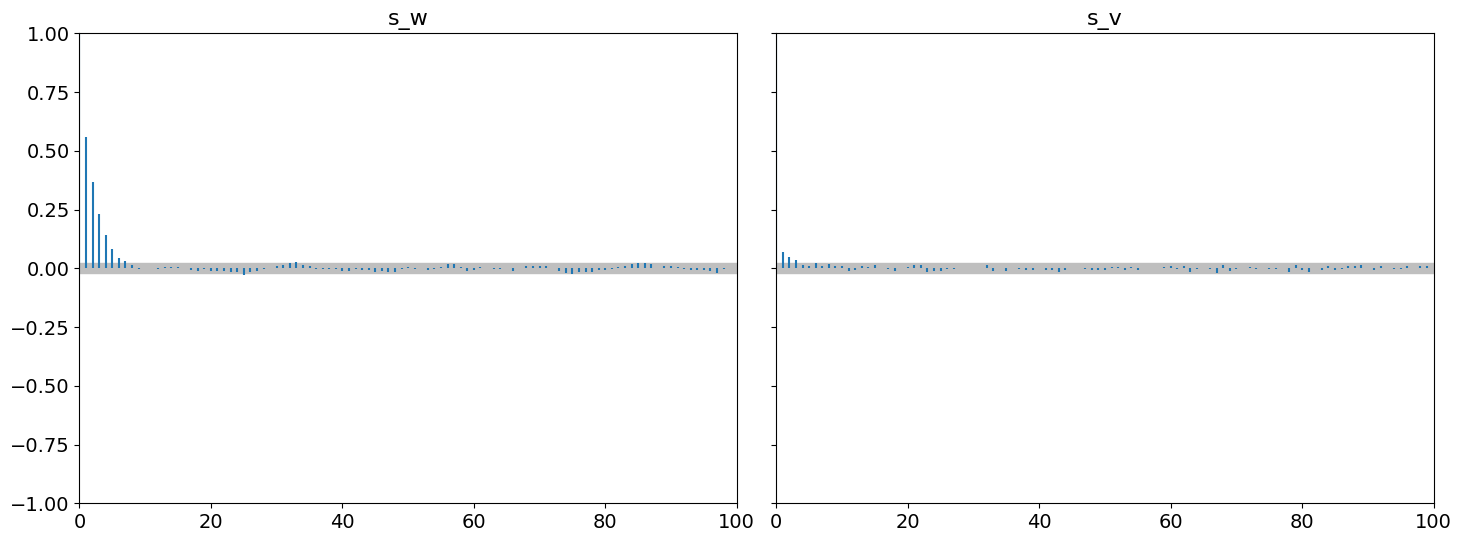

In [12]:
summary = az.summary(fit, var_names=["mu", "s_w", "s_v"])
display(summary)
az.plot_trace(fit, var_names=["s_w", "s_v"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["s_w", "s_v"], combined=True)
plt.tight_layout()

In [28]:
dt = pd.to_datetime(sales["date"])

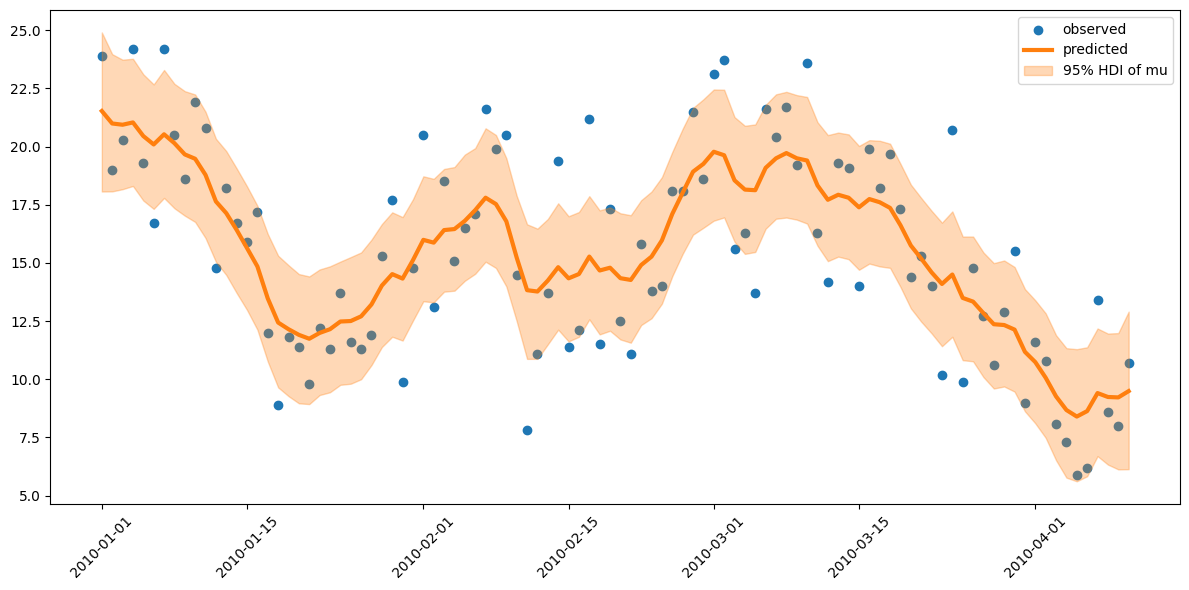

In [32]:
cmap = plt.get_cmap("tab10")

hdis = az.hdi(fit, hdi_prob=0.95)["mu"].values
mu_mean = az.summary(fit, var_names=["mu"])["mean"].values

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.scatter(dt, sales["sales"], color=cmap(0), label="observed")
axes.plot(dt, mu_mean, color=cmap(1), label="predicted", lw=3)
axes.fill_between(dt, y1=hdis[:,0], y2=hdis[:,1], color=cmap(1), alpha=0.30, label="95% HDI of mu")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
